# Model Results Visualization
This notebook is intended to pull model artifacts from the Neptune experiment logger and run it on a few samples from the dataset to see visualize how the different model's are segmenting the data. 

In [1]:
from neptune import Session
import pickle
from rasterio.plot import show
import pytorch_lightning as pl
import torch
import torchvision
import zipfile
from matplotlib import pyplot
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import segmentation_models_pytorch as smp

In [2]:
image_types = ['full_channel', 'rgb', 'ir', 'hsv', 'hsv_with_ir', 'veg_index']

In [3]:
f = open("image_samples.pkl", "rb")
image_samples = pickle.load(f)

In [4]:
# create session and import my project
sesh = Session.with_default_backend(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5"
                                "lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOGE5NDI0YTktNmE2ZC00ZWZjLTlkMjAtNjNmMTIwM2Q2ZTQzIn0=")
project = sesh.get_project("maxzvyagin/GIS")

In [5]:
experiments = project.get_experiments()

In [ ]:
experiments

In [8]:
e = experiments[0]
e.get_system_properties()
e.get_logs()['test_loss']['y']
e.state

{'id': 'GIS-132',
 'name': 'nucleus_fullchannel',
 'created': datetime.datetime(2020, 8, 17, 17, 59, 4, 816000, tzinfo=tzutc()),
 'finished': datetime.datetime(2020, 8, 17, 18, 48, 57, 657000, tzinfo=tzutc()),
 'running_time': 2992841,
 'owner': 'maxzvyagin',
 'storage_size': 31129702,
 'channels_size': 3938632,
 'size': 35068334,
 'tags': ['nucleus', 'itype', 'precision'],
 'notes': '',
 'description': '',
 'hostname': 'nucleus'}

'0.10389262437820435'

'succeeded'

terrible


Text(0.5, 0.98, 'Experiment: terrible, Test Loss: 0.632626739286241')

(1, 1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

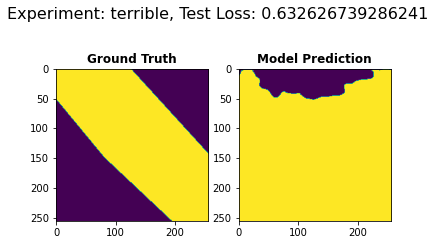

Text(0.5, 0.98, 'Experiment: terrible, Test Loss: 0.632626739286241')

(1, 1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

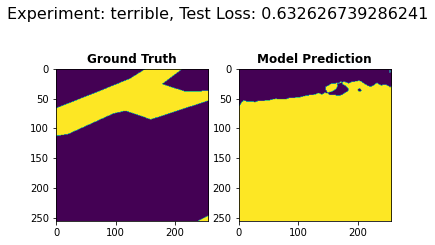

Text(0.5, 0.98, 'Experiment: terrible, Test Loss: 0.632626739286241')

(1, 1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

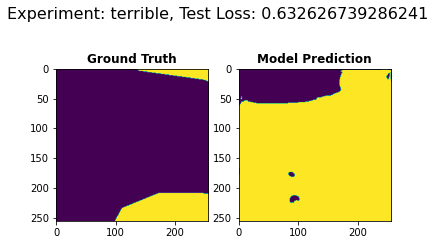

In [8]:
for e in experiments:
    id_num = int(e.get_system_properties()['id'].split('GIS-')[1])
    encoder = e.get_system_properties()['tags'][-1]
    if "encoder" in encoder:
        encoder = encoder.split("encoder")[1].lower()
    else:
        encoder = encoder.lower()
    if id_num == 287 and e.state == 'succeeded':
        # load in the model
        e.download_artifacts()
        with zipfile.ZipFile('output.zip') as zip_ref:
            zip_ref.extractall()
        f = open('output/latest_model.pkl', 'rb')
        device = torch.device('cpu')
        old_params = torch.load(f, map_location=device)
        params = dict()
        i_type = e.get_parameters()['image_type']
        if i_type == "full_channel":
            input_num = 4
        elif i_type == "rgb":
            input_num = 3
        elif i_type == "ir":
            input_num = 1
        elif i_type == "hsv":
            input_num = 3
        elif i_type == "hsv_with_ir":
            input_num = 4
        elif i_type == "veg_index":
            input_num = 1
        else:
            i_type = 4
        model = smp.Unet(classes=1, in_channels=4)
        # fix the weird state dict key error
        for k in old_params.keys():
            new_key = k.split("model.")[1]
            params[new_key] = old_params[k]
        # saving to variable to suppress huge printout
        print(encoder)
        y = model.load_state_dict(params)
        f.close()
        y = model.eval()
        # check the image type, and get image samples for corresponding image type
        # run the model on each of the samples and show results
        # print experiment id, name, image type, and training/test loss
        # print(e.get_properties(), e.get_numeric_channels_values())
        # show mask, and then show the results from each 
        for test in image_samples[i_type]:
            fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
            fig.suptitle("Experiment: "+encoder+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
            if i_type == "veg_index":
                channel_input = test['image'].unsqueeze(0)
                channel_input = channel_input.unsqueeze(1)
                res = model(channel_input)
            else:
                res = model(test['image'].unsqueeze(0))
            unmodified_res = res.detach().numpy()    
            res = np.rint(res.detach().numpy())
            #res = np.reshape(res, (2, 256, 256))
            print(res.shape) 
            show(res, ax=i_axis, title="Model Prediction")
            show(test['mask'], ax=m_axis, title="Ground Truth")
            pyplot.show()
    

array([[[[0.18361272, 0.24424793, 0.20756519, ..., 0.30530313,
          0.29372522, 0.30422568],
         [0.15436539, 0.15492721, 0.1127029 , ..., 0.24838611,
          0.24012691, 0.28147382],
         [0.17273213, 0.20791048, 0.20791137, ..., 0.41563195,
          0.3956497 , 0.37936792],
         ...,
         [0.9256466 , 1.0447797 , 1.0396016 , ..., 1.0573927 ,
          1.0671809 , 1.1152788 ],
         [0.8248173 , 1.0469521 , 1.0495188 , ..., 1.0877641 ,
          1.087927  , 1.148253  ],
         [0.6165199 , 0.9596411 , 1.006568  , ..., 1.0727848 ,
          1.045926  , 0.9648013 ]]]], dtype=float32)

(1, 1, 256, 256)

array([[[[7.1303143e-06, 7.5760413e-06, 7.3031642e-06, ...,
          8.0530108e-06, 7.9603060e-06, 8.0443369e-06],
         [6.9247913e-06, 6.9286825e-06, 6.6422167e-06, ...,
          7.6074562e-06, 7.5448788e-06, 7.8633802e-06],
         [7.0531532e-06, 7.3056863e-06, 7.3056931e-06, ...,
          8.9923542e-06, 8.8144488e-06, 8.6720938e-06],
         ...,
         [1.4975106e-05, 1.6869752e-05, 1.6782618e-05, ...,
          1.7083883e-05, 1.7251914e-05, 1.8101986e-05],
         [1.3538806e-05, 1.6906441e-05, 1.6949885e-05, ...,
          1.7610691e-05, 1.7613564e-05, 1.8708835e-05],
         [1.0993039e-05, 1.5492931e-05, 1.6237291e-05, ...,
          1.7348862e-05, 1.6889102e-05, 1.5573070e-05]]]], dtype=float32)

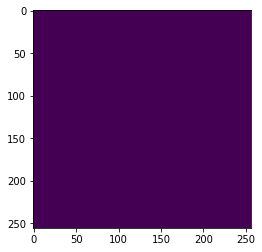

<AxesSubplot:>

In [12]:
from scipy.special import softmax
unmodified_res[:10]
calculation = softmax(unmodified_res)
calculation[:10]
show(np.rint(calculation))

In [19]:
test['mask']

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [ ]:
for e in experiments:
    # load in the model
    e.download_artifacts()
    with zipfile.ZipFile('output.zip') as zip_ref:
        zip_ref.extractall()
    f = open('output/latest_model.pkl', 'rb')
    device = torch.device('cpu')
    old_params = torch.load(f, map_location=device)
    params = dict()
    i_type = e.get_parameters()['image_type']
    if i_type == "full_channel":
        input_num = 4
    elif i_type == "rgb":
        input_num = 3
    elif i_type == "ir":
        input_num = 1
    elif i_type == "hsv":
        input_num = 3
    elif i_type == "hsv_with_ir":
        input_num = 4
    elif i_type == "veg_index":
        input_num = 1
    else:
        i_type = 4
    model =  torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=input_num,
                                    out_channels=1,
                                    init_features=32, pretrained=False)
    # fix the weird state dict key error
    for k in old_params.keys():
        new_key = k.split("model.")[1]
        params[new_key] = old_params[k]
    model.load_state_dict(params)
    f.close()
    # check the image type, and get image samples for corresponding image type
    # run the model on each of the samples and show results
    # print experiment id, name, image type, and training/test loss
    # print(e.get_properties(), e.get_numeric_channels_values())
    # show mask, and then show the results from each 
    for test in image_samples[i_type]:
        fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
        fig.suptitle("Experiment: "+e.get_system_properties()['name']+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
        if i_type == "veg_index":
            channel_input = test['image'].unsqueeze(0)
            channel_input = channel_input.unsqueeze(1)
            res = model(channel_input)
        else:
            res = model(test['image'].unsqueeze(0))
        res = np.rint(res.detach().numpy())
        show(res, ax=i_axis, title="Model Prediction")
        show(test['mask'], ax=m_axis, title="Ground Truth")
        pyplot.show()
    